In [59]:
#load Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix,  ConfusionMatrixDisplay, accuracy_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam



In [33]:


# Load the CSV file
df = pd.read_csv('creditcard.csv')

# Preview the data
print(df.head())
print(df.info())
print(df.describe())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [34]:
#Check for Class Imbalance
print(df['Class'].value_counts(normalize=True))


Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


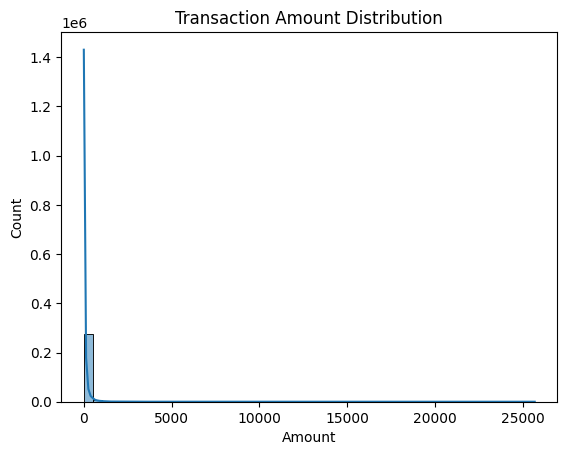

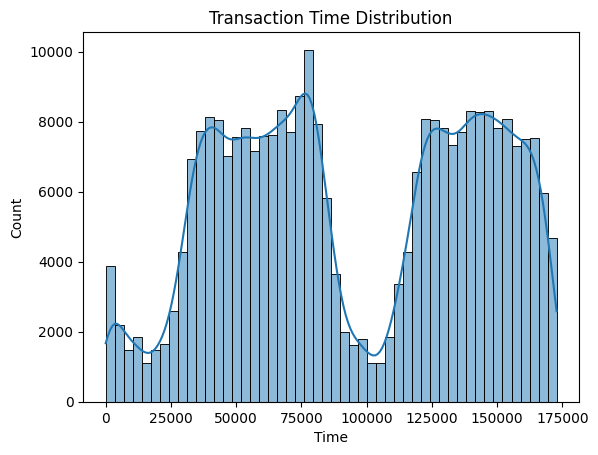

In [35]:
# Distribution of transaction amounts
sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()

# Distribution of time
sns.histplot(df['Time'], bins=50, kde=True)
plt.title("Transaction Time Distribution")
plt.show()


In [36]:
#drop label (class)
X = df.drop(columns=['Class'])  # Features only
y = df['Class']  # Save for later evaluation


In [37]:
#scale Amount and Time
X['Amount'] = StandardScaler().fit_transform(X[['Amount']])
X['Time'] = StandardScaler().fit_transform(X[['Time']])


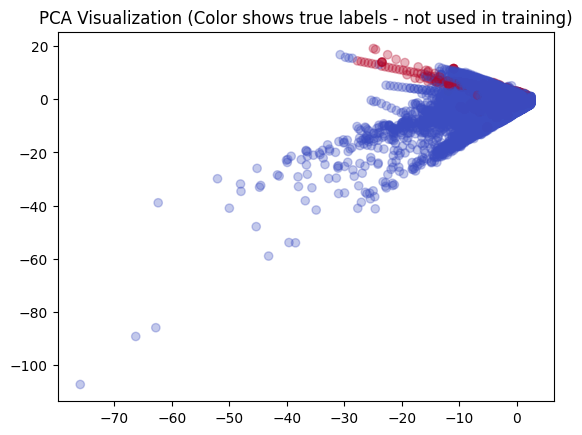

In [38]:
#Reduce Dimensionality for Visualization using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Visualize reduced dimensions (optional)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.3)
plt.title("PCA Visualization (Color shows true labels - not used in training)")
plt.show()


In [39]:
#Isolation Forest to detect anomalies 
iso_forest = IsolationForest(contamination=0.0017, random_state=42)
y_pred_iso = iso_forest.fit_predict(X)

# Convert output to 0 (normal), 1 (anomaly)
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]


In [40]:
#Evaluate the model
print("Isolation Forest Report:")
print(classification_report(y, y_pred_iso))
print(confusion_matrix(y, y_pred_iso))

Isolation Forest Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.26      0.25      0.26       492

    accuracy                           1.00    284807
   macro avg       0.63      0.63      0.63    284807
weighted avg       1.00      1.00      1.00    284807

[[283955    360]
 [   367    125]]


In [41]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Only use normal transactions for training
X_train = X_scaled[y == 0]

In [ ]:
#Build Autoencoder Model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')


In [46]:
#train the Autoencoder 
history = autoencoder.fit(X_train, X_train,
                          epochs=10,
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.1,
                          verbose=1)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8260 - val_loss: 0.6196
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5648 - val_loss: 0.5285
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4988 - val_loss: 0.4929
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4738 - val_loss: 0.4815
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4640 - val_loss: 0.4709
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4569 - val_loss: 0.4645
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.4495 - val_loss: 0.4649
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4468 - val_loss: 0.4618
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4430 - val_loss: 0.4645
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4467 - val_loss: 0.4639


In [47]:
# Get reconstruction loss for all data
X_pred = autoencoder.predict(X_scaled)
mse = np.mean(np.power(X_scaled - X_pred, 2), axis=1)


8901/8901 ━━━━━━━━━━━━━━━━━━━━ 5s 569us/step


In [48]:
# Set threshold as 95th percentile of normal data error
threshold = np.percentile(mse[y == 0], 95)

# Predict frauds
preds_ae = [1 if e > threshold else 0 for e in mse]


In [58]:
#Evaluate
print("Autoencoder Report:")
print(classification_report(y, preds_ae))
print(confusion_matrix(y, preds_ae))



Autoencoder Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    284315
           1       0.03      0.84      0.05       492

    accuracy                           0.95    284807
   macro avg       0.51      0.90      0.51    284807
weighted avg       1.00      0.95      0.97    284807

[[270099  14216]
 [    77    415]]


Accuracy Comparison:
Isolation Forest: 0.9974473942002829
Autoencoder:       0.9498151379706257


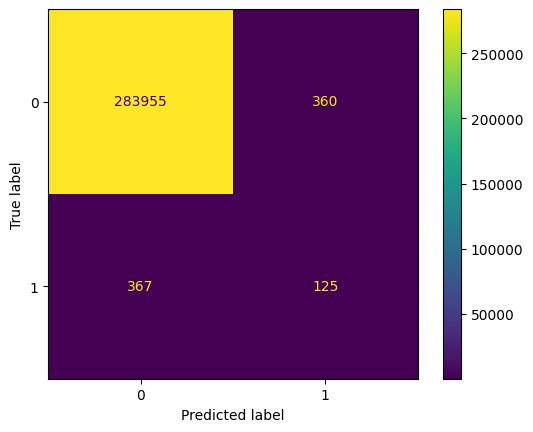

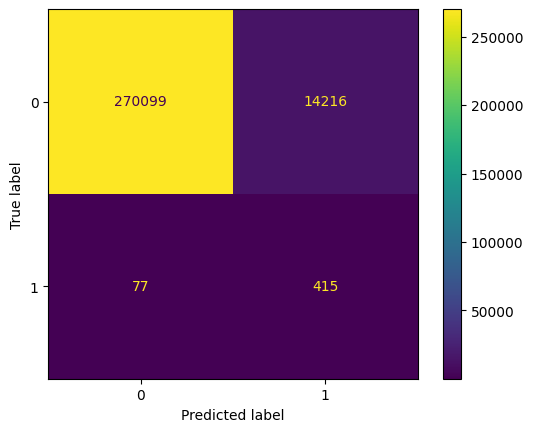

In [62]:
#compare the accuracy between 'Isolation Forest' and 'Autoencoder'
print("Accuracy Comparison:")
print("Isolation Forest:", accuracy_score(y, y_pred_iso))
print("Autoencoder:      ", accuracy_score(y, preds_ae))
ConfusionMatrixDisplay.from_predictions(y, y_pred_iso)
ConfusionMatrixDisplay.from_predictions(y, preds_ae)


In [ ]:
#Combine Predictions(Isolation forest) with Original Data
df['Anomaly'] = y_pred_iso  


In [64]:
#Filter Flagged Transactions 
#Get the transactions the model flagged as anomalies (predicted frauds)
flagged = df[df['Anomaly'] == 1]


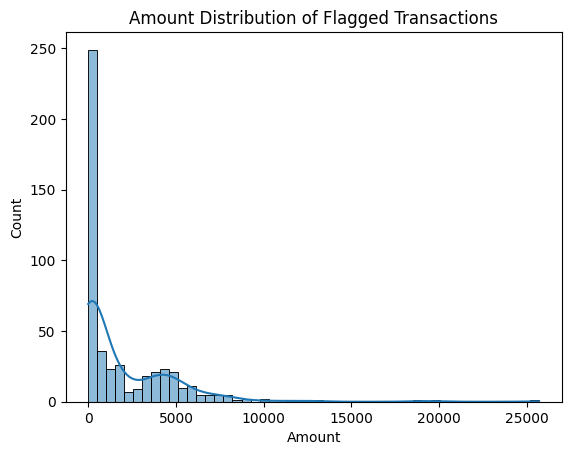

In [65]:
# Analyze Flagged Transactions
sns.histplot(flagged['Amount'], bins=50, kde=True)
plt.title("Amount Distribution of Flagged Transactions")
plt.show()

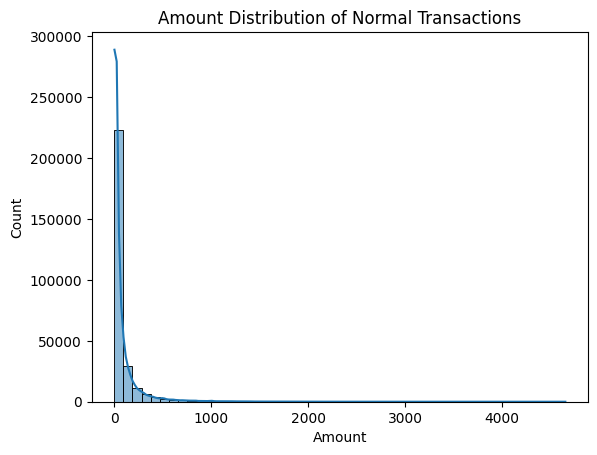

In [66]:
#Compare with the amount distribution of normal transactions:
sns.histplot(df[df['Anomaly'] == 0]['Amount'], bins=50, kde=True)
plt.title("Amount Distribution of Normal Transactions")
plt.show()


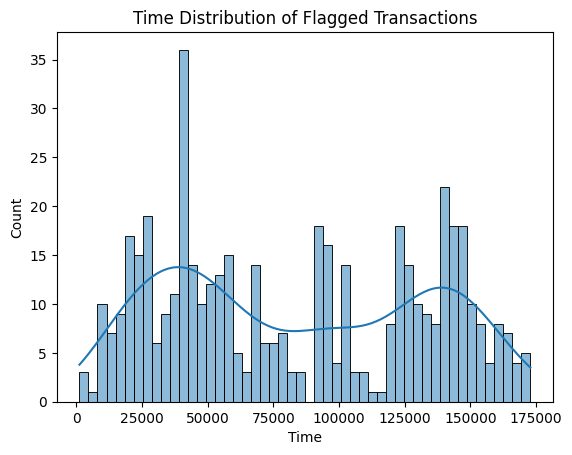

In [67]:
#Time of Transaction
sns.histplot(flagged['Time'], bins=50, kde=True)
plt.title("Time Distribution of Flagged Transactions")
plt.show()


In [74]:
flagged_means = flagged.iloc[:, 0:28].mean()
normal_means = df[df['Anomaly'] == 0].iloc[:, 0:28].mean()

diff = (flagged_means - normal_means).abs().sort_values(ascending=False)
print("Top PCA features differing in flagged transactions:")
print(diff.head(10))


Top PCA features differing in flagged transactions:
Time    10923.349690
V1         15.037235
V3         10.053619
V2          7.138323
V5          6.594607
V4          5.272624
V17         4.868543
V10         3.854224
V12         3.446146
V8          3.120786
dtype: float64


After comparing both unsupervised models for credit card fraud detection, we observed the following:

 Isolation Forest achieved very high overall accuracy (99.7%), but with low recall (25%) for fraud cases. This means it missed most actual frauds, making it more conservative and cautious when flagging anomalies.

 Autoencoder, while having slightly lower overall accuracy (94.9%), achieved a much higher recall (84%), successfully identifying most fraudulent transactions. However, it came at the cost of low precision (3%), meaning it flagged many normal transactions as fraudulent.

 In the context of fraud detection, recall is more important than precision — it is far more critical to catch fraud than to avoid false alarms. Therefore, despite the false positives, the Autoencoder performed better overall in identifying rare fraud patterns in unlabeled data.